In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from jcopml.time_series.decomposition import additive_decomposition, multiplicative_decomposition, stl_decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_excel("cabe_fixed.xlsx", parse_dates=["Tanggal"], index_col='Tanggal', usecols=['Tanggal', 'Pasar Induk Kramat Jati', 'Pasar Grogol', 'Pasar Minggu', 'Pasar Koja Baru'])
df.tail()

,Pasar Induk Kramat Jati,Pasar Grogol,Pasar Minggu,Pasar Koja Baru
Tanggal,,,,
2023-05-08,24000,30000,40000,40000
2023-06-12,29000,43000,40000,60000
2023-06-19,27000,40000,40000,50000
2023-07-11,19000,30000,35000,45000
2023-07-13,18000,30000,35000,45000


In [3]:
df.shape

(1143, 4)

In [15]:
columns_to_plot = ['Pasar Induk Kramat Jati', 'Pasar Grogol', 'Pasar Minggu', 'Pasar Koja Baru']

means = {}
for col in columns_to_plot:
    means[col] = df.groupby('Tanggal')[col].mean().reset_index()

fig = make_subplots(rows=2, cols=2, subplot_titles=columns_to_plot)

for i, col in enumerate(columns_to_plot):
    row = i // 2 + 1
    col_num = i % 2 + 1
    fig.add_trace(go.Scatter(x=means[col]['Tanggal'], y=means[col][col], mode='lines', name=col),
                  row=row, col=col_num)

fig.update_xaxes(title_text='Tanggal')
fig.update_yaxes(title_text='Value')

fig.update_layout(title_text='Average Over Time', showlegend=False)
fig.update_layout(height=800, width=1000, template='plotly_dark')

fig.show()

In [4]:
df.dropna(inplace=True)

In [54]:
from  scipy.stats import skew, kurtosis, shapiro
mean = np.mean(df['Pasar Minggu'].values)
std = np.std(df['Pasar Minggu'].values)
skew = skew(df['Pasar Minggu'].values)
ex_kurt = kurtosis(df['Pasar Minggu'])
print("Skewness: {} \nKurtosis: {}".format(skew, ex_kurt+3))

Skewness: 0.8878909309293015 
Kurtosis: 3.3054518695049797


In [6]:
def shapiro_test(df, alpha=0.05):
    stat, pval = shapiro(df)
    print("H0: Data was drawn from a Normal Ditribution")
    if (pval<alpha):
        print("pval {} is lower than significance level: {}, therefore null hypothesis is rejected".format(pval, alpha))
    else:
        print("pval {} is higher than significance level: {}, therefore null hypothesis cannot be rejected".format(pval, alpha))
        
shapiro_test(df['Pasar Minggu'], alpha=0.05)

H0: Data was drawn from a Normal Ditribution
pval 1.9931477960449867e-24 is lower than significance level: 0.05, therefore null hypothesis is rejected


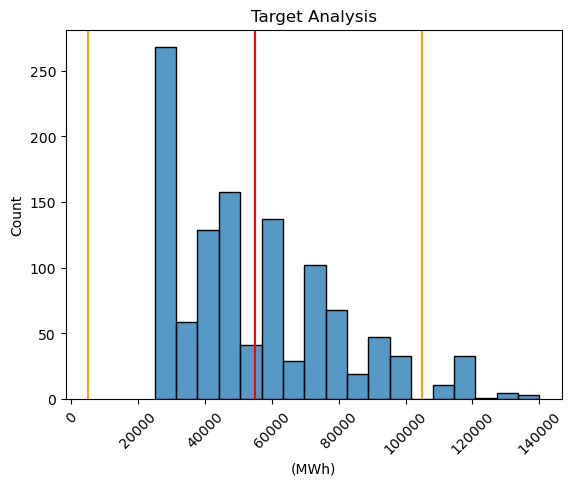

In [7]:
sns.histplot(df['Pasar Minggu'])
plt.title("Target Analysis")
plt.xticks(rotation=45)
plt.xlabel("(MWh)")
plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
plt.show()

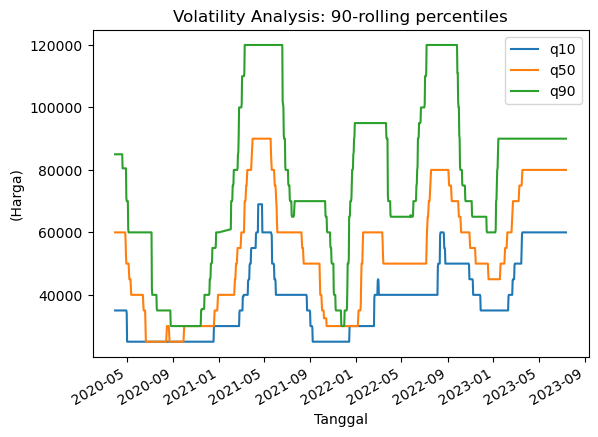

In [8]:
# Insert the rolling quantiles to the monthly returns
data_rolling = df['Pasar Minggu'].rolling(window=90)
df['q10'] = data_rolling.quantile(0.1).to_frame("q10")
df['q50'] = data_rolling.quantile(0.5).to_frame("q50")
df['q90'] = data_rolling.quantile(0.9).to_frame("q90")

df[["q10", "q50", "q90"]].plot(title="Volatility Analysis: 90-rolling percentiles")
plt.ylabel("(Harga)")
plt.show()

C:\Users\khris\AppData\Local\Temp\ipykernel_4572\1227180188.py:4: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



<Figure size 2000x1600 with 0 Axes>

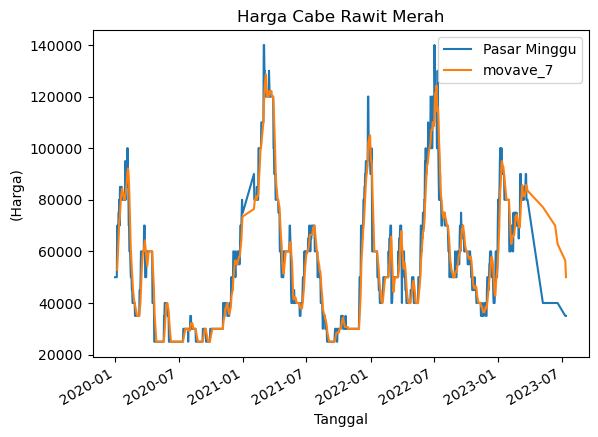

In [9]:
df["year"] = df['Pasar Minggu'].index.year
df["qtr"] = df['Pasar Minggu'].index.quarter
df["mon"] = df['Pasar Minggu'].index.month
df["week"] = df['Pasar Minggu'].index.week
df["day"] = df['Pasar Minggu'].index.weekday
df["ix"] = range(0,len(df))
df[["movave_7", "movstd_7"]] = df['Pasar Minggu'].rolling(7).agg([np.mean, np.std])
df[["movave_30", "movstd_30"]] = df['Pasar Minggu'].rolling(30).agg([np.mean, np.std])
df[["movave_90", "movstd_90"]] = df['Pasar Minggu'].rolling(90).agg([np.mean, np.std])
df[["movave_365", "movstd_365"]] = df['Pasar Minggu'].rolling(365).agg([np.mean, np.std])

plt.figure(figsize=(20,16))
df[["Pasar Minggu", "movave_7"]].plot(title="Harga Cabe Rawit Merah")
plt.ylabel("(Harga)")
plt.show()

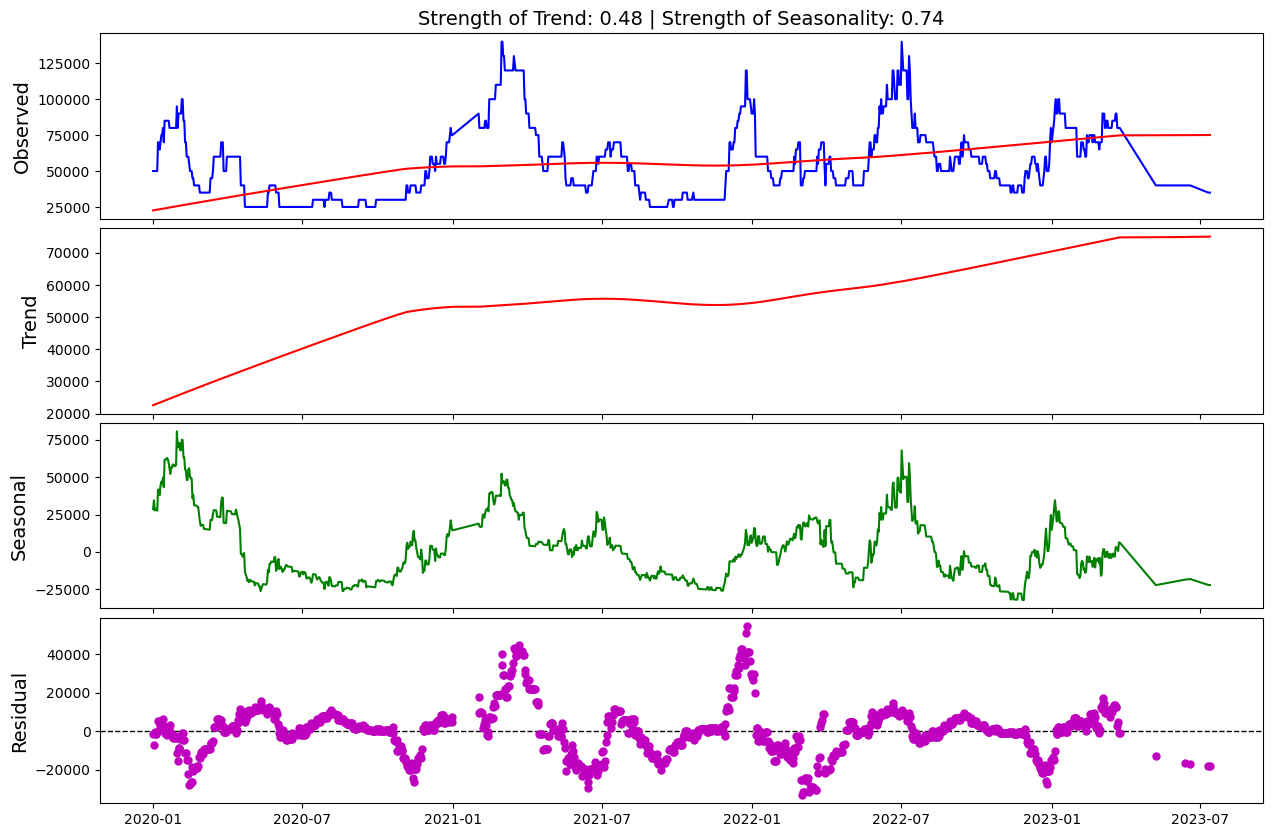

In [17]:
series = df['Pasar Minggu']
components = stl_decomposition(series, plot=True, period=365)

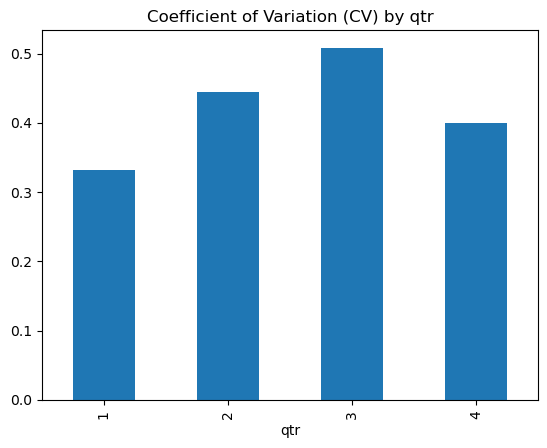

In [18]:
df.groupby("qtr")["Pasar Minggu"].std().divide(df.groupby("qtr")["Pasar Minggu"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by qtr")
plt.show()

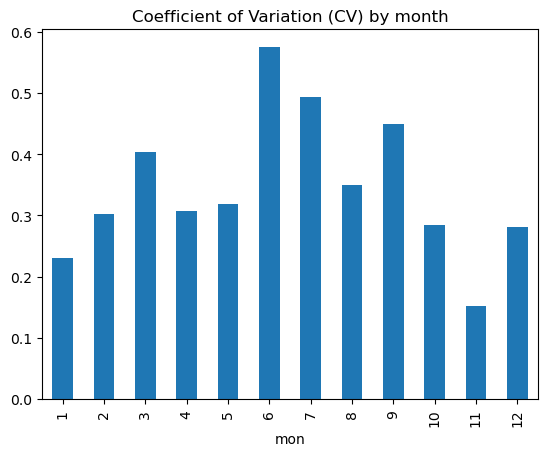

In [19]:
df.groupby("mon")["Pasar Minggu"].std().divide(df.groupby("mon")["Pasar Minggu"].mean()).plot(kind="bar")
plt.title("Coefficient of Variation (CV) by month")
plt.show()

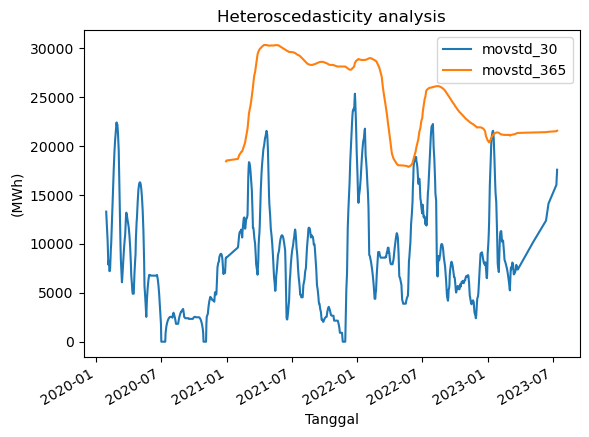

In [20]:
df[["movstd_30", "movstd_365"]].plot(title="Heteroscedasticity analysis")
plt.ylabel("(MWh)")
plt.show()

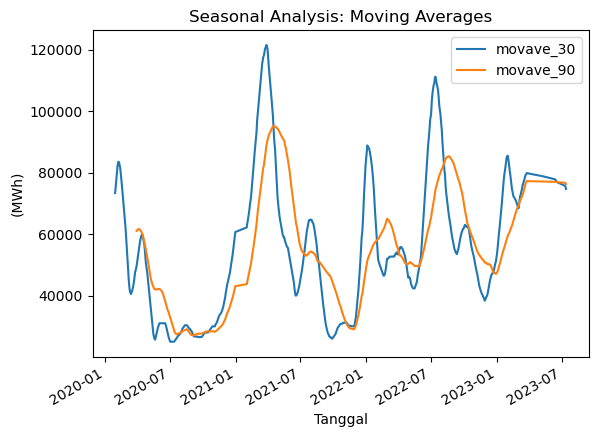

In [21]:
df[["movave_30", "movave_90"]].plot(title="Seasonal Analysis: Moving Averages")
plt.ylabel("(MWh)")
plt.show()

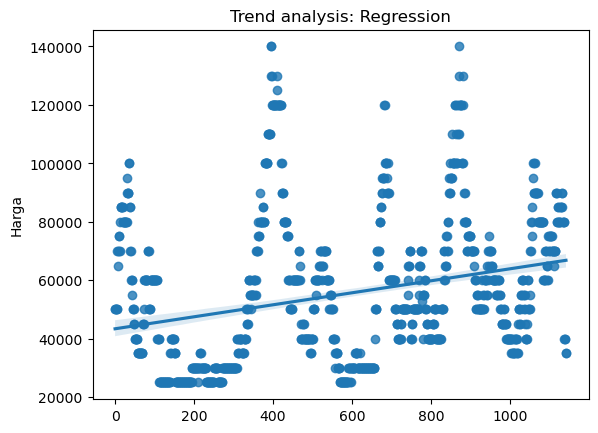

In [22]:
sns.regplot(data=df,x="ix", y="Pasar Minggu")
plt.title("Trend analysis: Regression")
plt.ylabel("Harga")
plt.xlabel("")
plt.show()

C:\Users\khris\AppData\Local\Temp\ipykernel_4572\2692754778.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




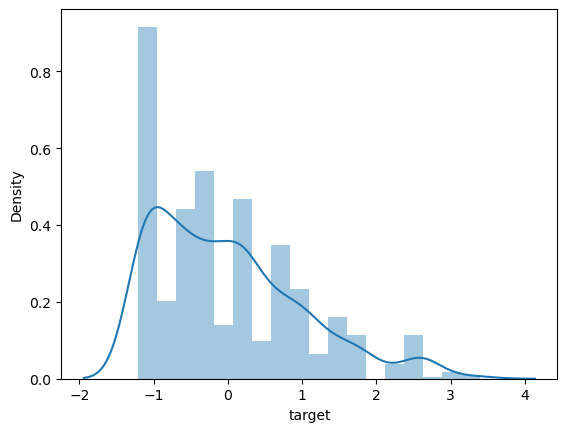

In [23]:
df["target"] = df['Pasar Minggu'].add(-mean).div(std)
sns.distplot(df["target"])
plt.show()

In [24]:
features = []
corr_features=[]
targets = []
tau = 30 #forecasting periods

for t in range(1, tau+1):
    df["target_t" + str(t)] = df.target.shift(-t)
    targets.append("target_t" + str(t))
    
for t in range(1,31):
    df["feat_ar" + str(t)] = df.target.shift(t)
    #data["feat_ar" + str(t) + "_lag1y"] = data.target.shift(350)
    features.append("feat_ar" + str(t))
    #corr_features.append("feat_ar" + str(t))
    #features.append("feat_ar" + str(t) + "_lag1y")
        
    
for t in [7, 14, 30]:
    df[["feat_movave" + str(t), "feat_movstd" + str(t), "feat_movmin" + str(t) ,"feat_movmax" + str(t)]] = df['Pasar Minggu'].rolling(t).agg([np.mean, np.std, np.max, np.min])
    features.append("feat_movave" + str(t))
    #corr_features.append("feat_movave" + str(t))
    features.append("feat_movstd" + str(t))
    features.append("feat_movmin" + str(t))
    features.append("feat_movmax" + str(t))
    
months = pd.get_dummies(df.mon,
                              prefix="mon",
                              drop_first=True)
months.index = df.index
df = pd.concat([df, months], axis=1)

days = pd.get_dummies(df.day,
                              prefix="day",
                              drop_first=True)
days.index = df.index
df = pd.concat([df, days], axis=1)


features = features + months.columns.values.tolist() + days.columns.values.tolist()

In [25]:
corr_features = ["feat_ar1", "feat_ar2", "feat_ar3", "feat_ar4", "feat_ar5", "feat_ar6", "feat_ar7", "feat_movave7", "feat_movave14", "feat_movave30"]

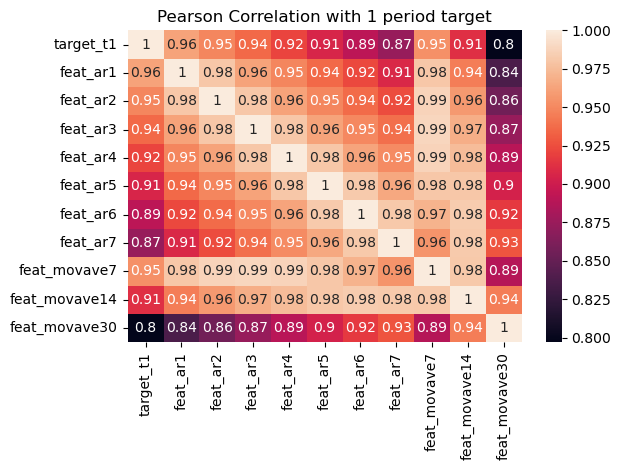

In [26]:
# Calculate correlation matrix
corr = df[["target_t1"] + corr_features].corr()

top5_mostCorrFeats = corr["target_t1"].apply(abs).sort_values(ascending=False).index.values[:6]


# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.title("Pearson Correlation with 1 period target")
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

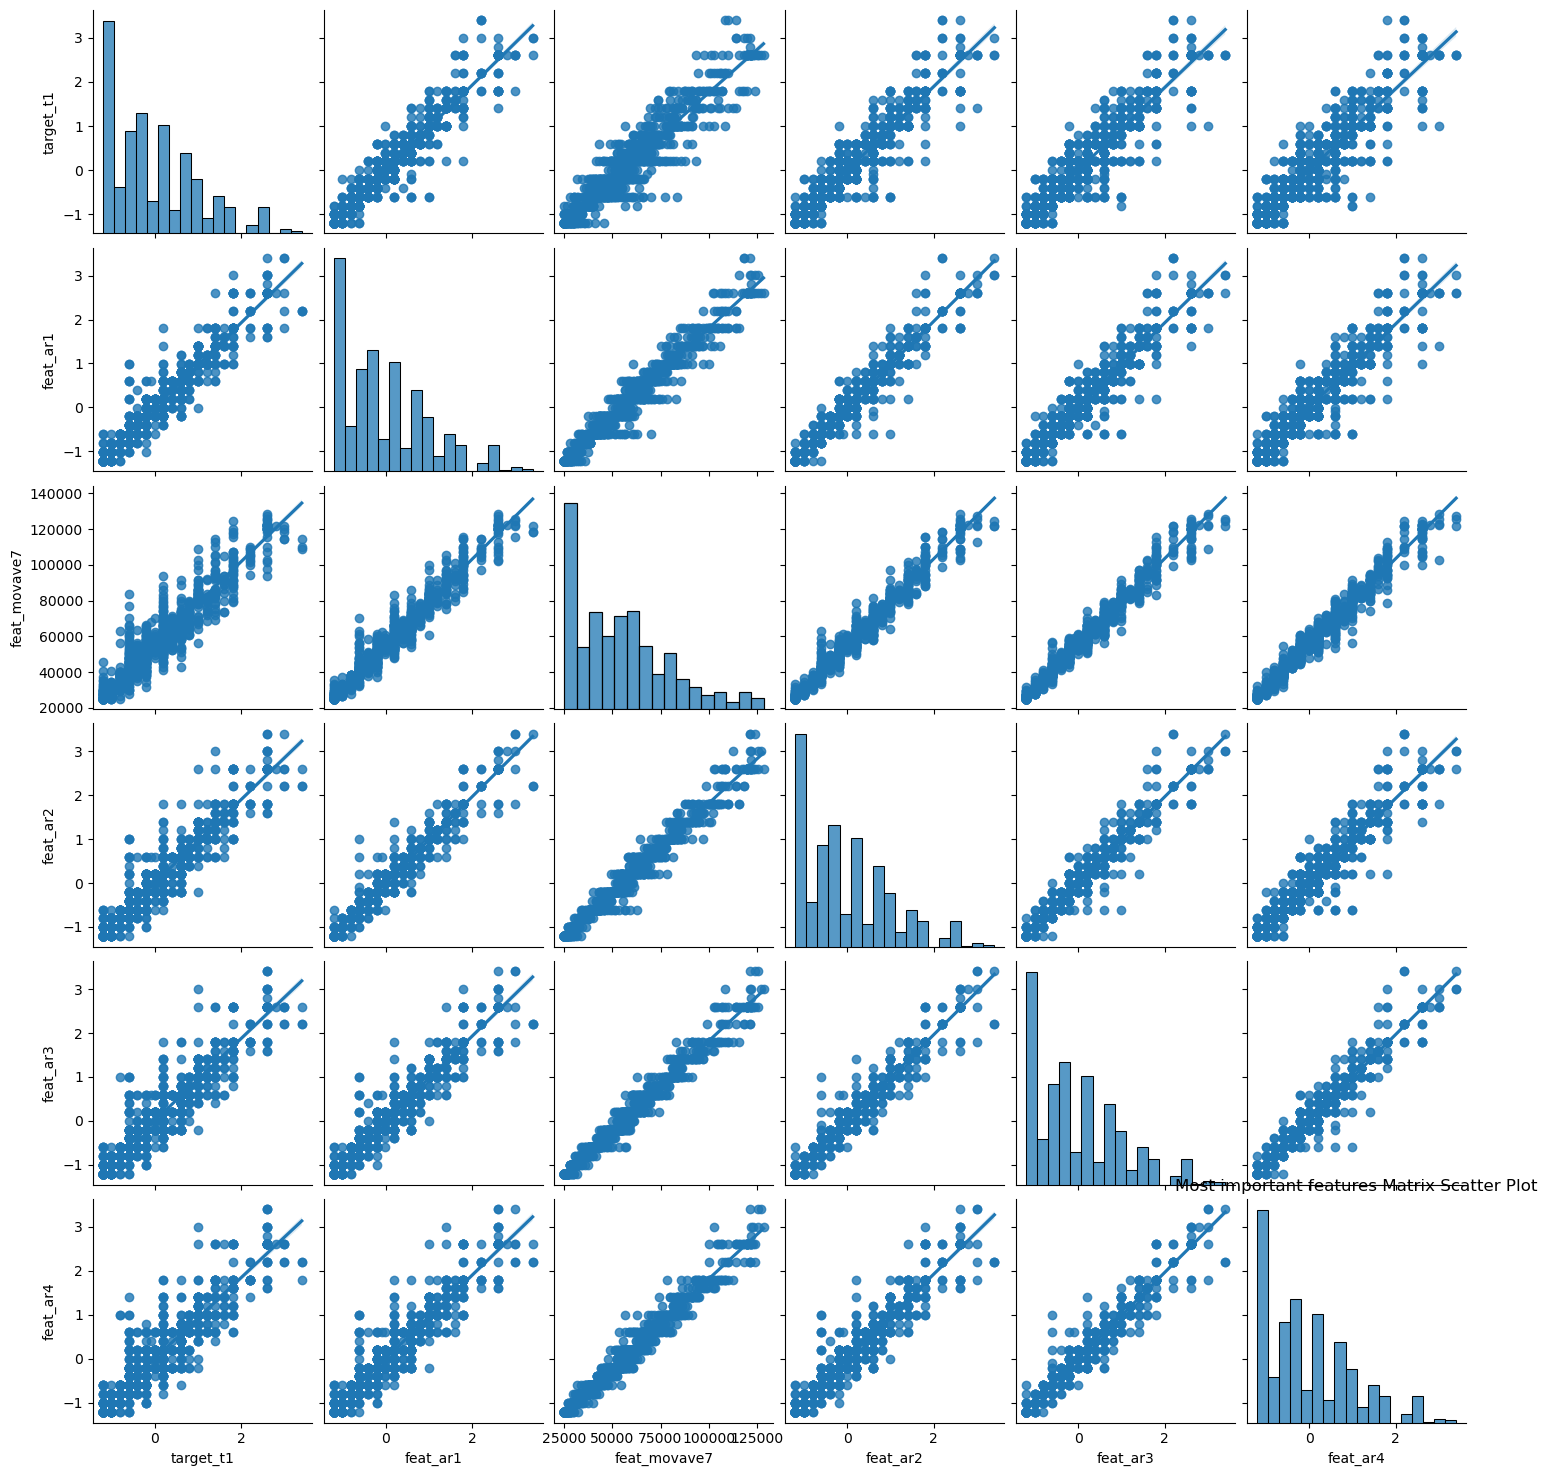

In [27]:
sns.pairplot(data=df[top5_mostCorrFeats].dropna(), kind="reg")
plt.title("Most important features Matrix Scatter Plot")
plt.show()

In [28]:
data_feateng = df[features + targets].dropna()
nobs= len(data_feateng)
print("Number of observations: ", nobs)

Number of observations:  1083


Total number of observations:  1083
Train: (1024, 59)(1024, 30), 
Test: (59, 59)(59, 30)


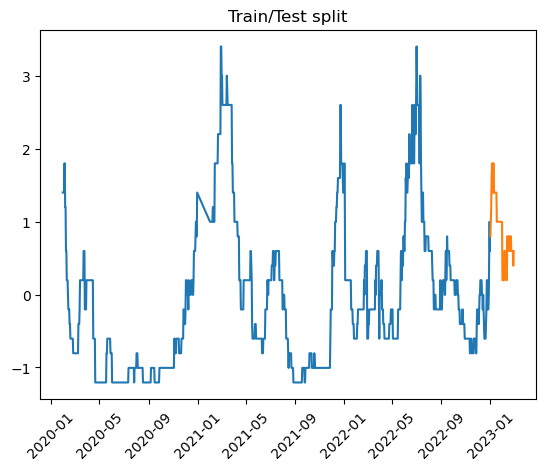

In [29]:
X_train = data_feateng.loc["2020":"2022"][features]
y_train = data_feateng.loc["2020":"2022"][targets]

X_test = data_feateng.loc["2023-"][features]
y_test = data_feateng.loc["2023"][targets]

n, k = X_train.shape
print("Total number of observations: ", nobs)
print("Train: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,
                                              X_test.shape, y_test.shape))

plt.plot(y_train.index, y_train.target_t1.values, label="train")
plt.plot(y_test.index, y_test.target_t1.values, label="test")
plt.title("Train/Test split")
plt.xticks(rotation=45)
plt.show()

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression().fit(X_train, y_train["target_t1"])
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train["target_t1"], p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test["target_t1"], p_test))

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test) )

Train RMSE: 0.17443245330418802
Test RMSE: 0.21767064560424146


TRAIN: 256 TEST: 256


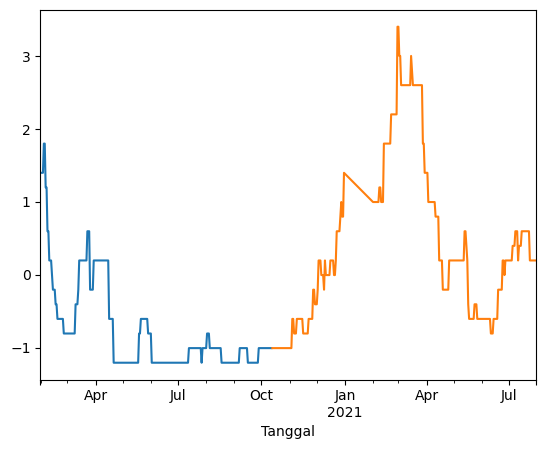

TRAIN: 512 TEST: 256


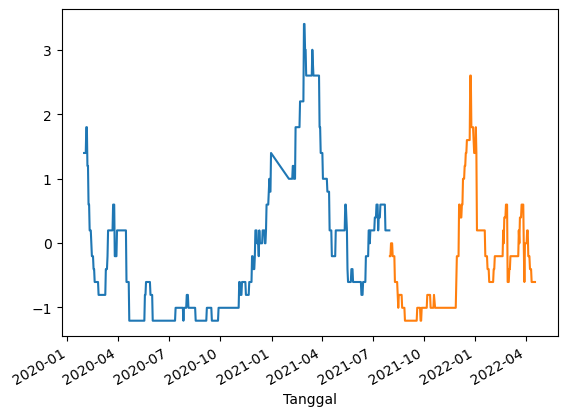

TRAIN: 730 TEST: 256


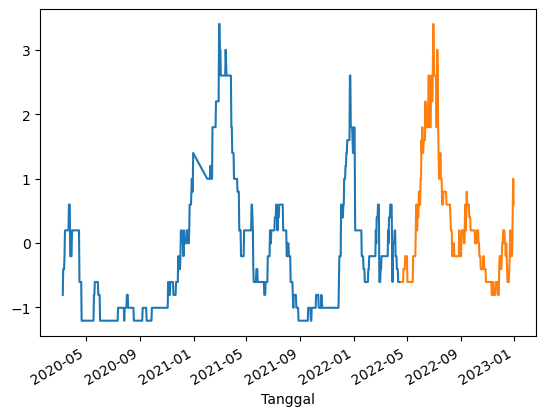

In [31]:
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
for train_index, val_index in splits.split(X_train):
    print("TRAIN:", len(train_index), "TEST:", len(val_index))
    y_train["target_t1"][train_index].plot()
    y_train["target_t1"][val_index].plot()
    plt.show()

In [32]:
from sklearn.ensemble import RandomForestRegressor

splits = TimeSeriesSplit(n_splits=3, max_train_size=365*2)
rfr = RandomForestRegressor()
# Create a dictionary of hyperparameters to search
rfr_grid = {"n_estimators": [500], 
        'max_depth': [3, 5, 10, 20, 30], 
        'max_features': [4, 8, 16, 32, 59], 
        'random_state': [123]}
rfr_paramGrid = ParameterGrid(rfr_grid)

def TimeSplit_ModBuild(model, paramGrid, splits, X, y):
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error

    #Loop over each time split and for each
    for train_index, val_index in splits.split(X_train):
        _X_train_ = X.iloc[train_index]
        _y_train_ = y.iloc[train_index]
        _X_val_ = X.iloc[val_index]
        _y_val_ = y.iloc[val_index]

        train_scores = []
        val_scores = []
        #models = []
        
        # Loop through the parameter grid, set the hyperparameters, and save the scores
        for g in paramGrid:
            model.set_params(**g)
            model.fit(_X_train_, _y_train_)
            p_train = model.predict(_X_train_)
            p_val = model.predict(_X_val_)
            score_train = np.mean(mean_squared_error(_y_train_, p_train))
            score_val = np.mean(mean_squared_error(_y_val_, p_val))
            train_scores.append(score_train)
            val_scores.append(score_val)
            #models.append(model)
            best_idx = np.argmin(val_scores)
            
        print("Best-Fold HyperParams:: ", paramGrid[best_idx])
        print("Best-Fold Train RMSE: ", train_scores[best_idx])
        print("Best-Fold Val RMSE: ",val_scores[best_idx])
        print("\n")
        
    #Return most recent model
    return train_scores, val_scores, best_idx


CV_rfr_tup = TimeSplit_ModBuild(rfr, rfr_paramGrid, splits, X_train, y_train["target_t1"])

Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 59, 'max_depth': 5}
Best-Fold Train RMSE:  0.006467862425297818
Best-Fold Val RMSE:  0.3183769164137008


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 32, 'max_depth': 5}
Best-Fold Train RMSE:  0.016378537660427107
Best-Fold Val RMSE:  0.07244127929165309


Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 32, 'max_depth': 5}
Best-Fold Train RMSE:  0.023433898485673094
Best-Fold Val RMSE:  0.07892241037868993




In [33]:
best_rfr_idx = CV_rfr_tup[2]
best_rfr_grid = rfr_paramGrid[best_rfr_idx]
best_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train.loc["2022":"2023"], y_train.loc["2022":"2023", "target_t1"])

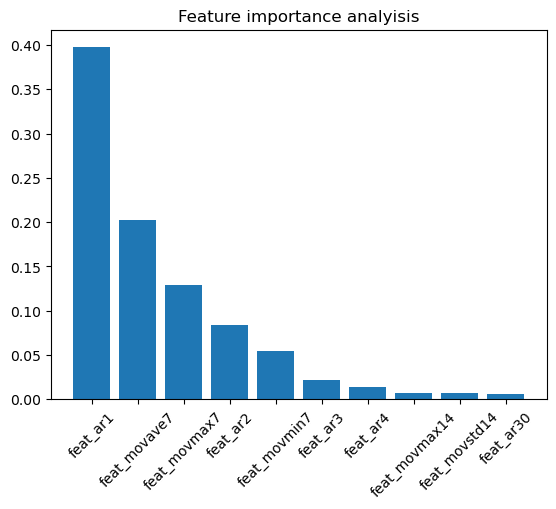

In [34]:
# Get feature importances from our random forest model
importances = best_rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
sorted_index_top = sorted_index[:10]
x = range(len(sorted_index_top))

# Create tick labels 
labels = np.array(features)[sorted_index_top]
plt.bar(x, importances[sorted_index_top], tick_label=labels)
plt.title("Feature importance analyisis")
# Rotate tick labels to vertical
plt.xticks(rotation=45)
plt.show()

In [35]:
p_train = best_rfr.predict(X_train)
train_resid_1step = y_train["target_t1"]- p_train

p_test = best_rfr.predict(X_test)
test_resid_1step = y_test["target_t1"]- p_test

In [36]:
test_df = y_test[["target_t1"]]*std+mean
test_df["pred_t1"] = p_test*std+mean
test_df["resid_t1"] = test_df["target_t1"].add(-test_df["pred_t1"])
test_df["abs_resid_t1"] = abs(test_df["resid_t1"])
test_df["ape_t1"] = test_df["resid_t1"].div(test_df["target_t1"])

test_MAPE = test_df["ape_t1"].mean()*100
print("1-period ahead forecasting MAPE: ", test_MAPE)

1-period ahead forecasting MAPE:  1.4680241891561128


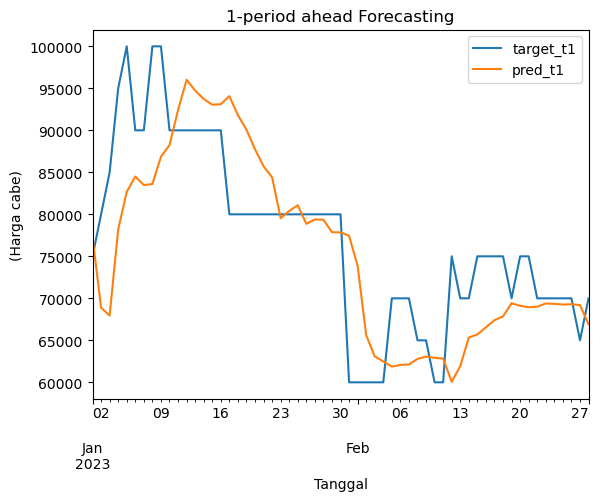

In [37]:
test_df[["target_t1", "pred_t1"]].plot()

plt.title("1-period ahead Forecasting")
plt.ylabel("(Harga cabe)")
plt.legend()
plt.show()

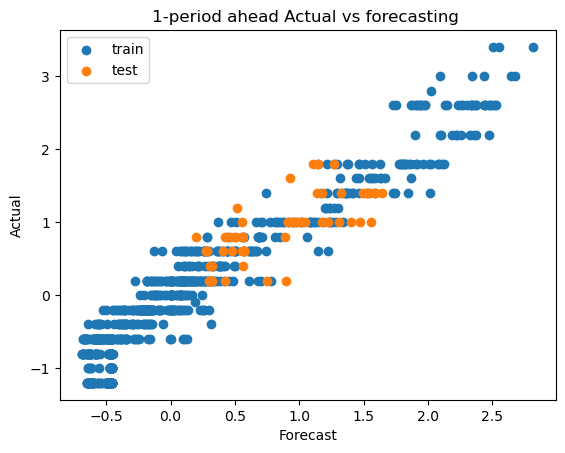

In [38]:
plt.scatter(y=y_train["target_t1"],x=p_train, label="train")
plt.scatter(y=y_test["target_t1"],x=p_test, label="test")
plt.title("1-period ahead Actual vs forecasting ")
plt.ylabel("Actual")
plt.xlabel("Forecast")
plt.legend()
plt.show()

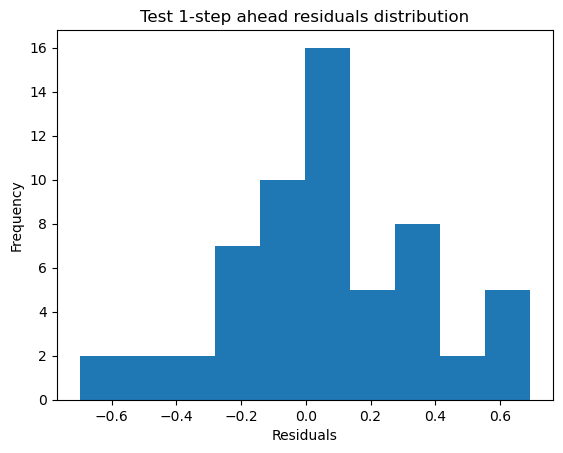

In [39]:
test_resid_1step.plot.hist(bins=10, title="Test 1-step ahead residuals distribution")
plt.xlabel("Residuals")
plt.show()

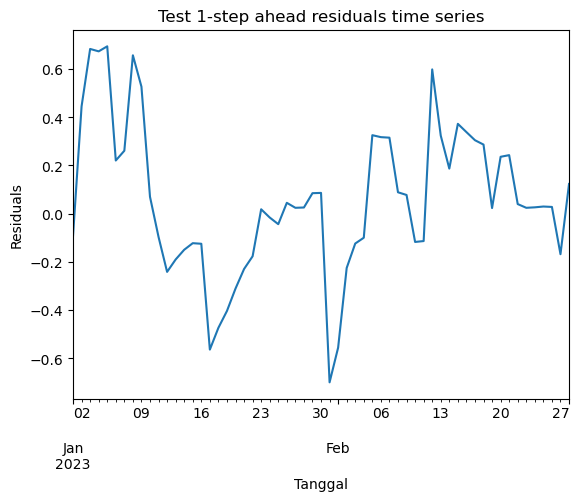

In [40]:
test_resid_1step.plot(title="Test 1-step ahead residuals time series")
plt.ylabel("Residuals")
plt.show()

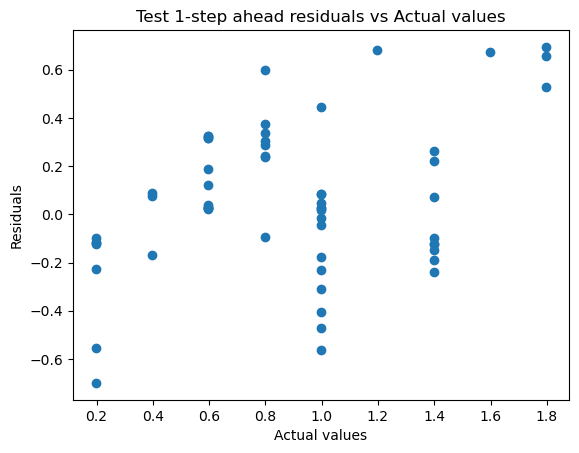

In [41]:
plt.scatter(x=y_test["target_t1"].values, y=test_resid_1step.values)
plt.title("Test 1-step ahead residuals vs Actual values")
plt.ylabel("Residuals")
plt.xlabel("Actual values")
plt.show()

In [42]:
multi_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train.loc["2022":"2023"], y_train.loc["2022":"2023"])

In [43]:
p_train = multi_rfr.predict(X_train)
train_resid_1step = y_train- p_train

p_test = multi_rfr.predict(X_test)
test_resid_1step = y_test- p_test

In [44]:
periods = [1, 7, 14, 30]

ytest_df = y_test*std+mean
ptest_df = pd.DataFrame(data=p_test*std+mean, index=test_df.index, columns=["pred_t" + str(i) for i in range(1, 31)])
test_df = pd.concat([ytest_df, ptest_df], axis=1)

test_MAPE = []

for t in periods:
    test_df["resid_t" + str(t)] = test_df["target_t" + str(t)].add(-test_df["pred_t" + str(t)])
    test_df["abs_resid_t" + str(t)] = abs(test_df["resid_t" + str(t)])
    test_df["ape_t" + str(t)] = test_df["abs_resid_t" + str(t)].div(test_df["target_t" + str(t)])
    test_MAPE.append(round(test_df["ape_t" + str(t)].mean(), 4)*100)

print("MAPE test: ", test_MAPE)

MAPE test:  [14.67, 17.71, 20.45, 25.4]


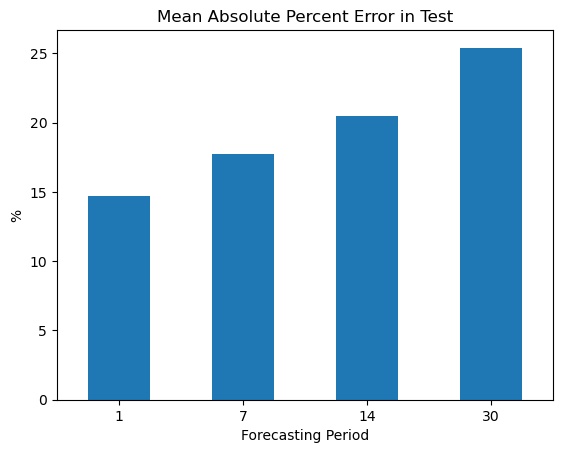

In [45]:
mape_df = pd.DataFrame(index=periods, data={"test_MAPE": test_MAPE})
mape_df.plot(kind="bar", legend=False)
plt.title("Mean Absolute Percent Error in Test")
plt.xlabel("Forecasting Period")
plt.ylabel("%")
plt.xticks(rotation=0)
plt.show()

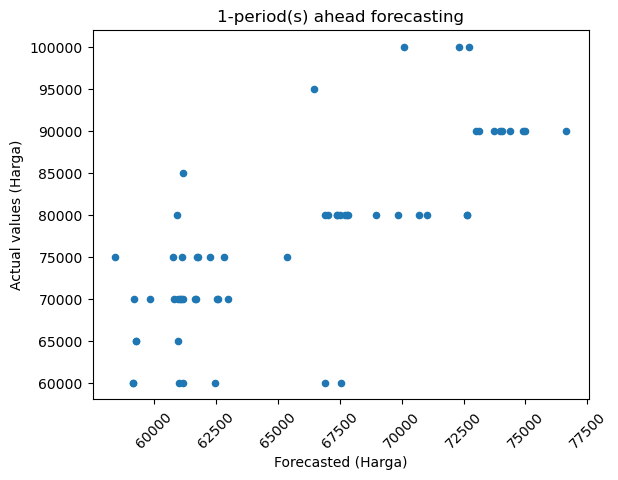

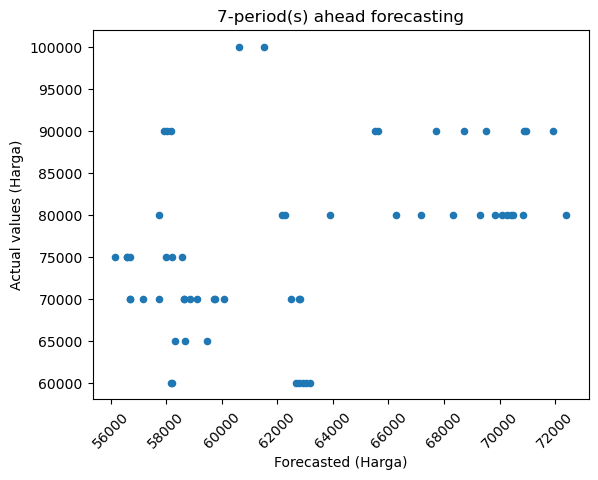

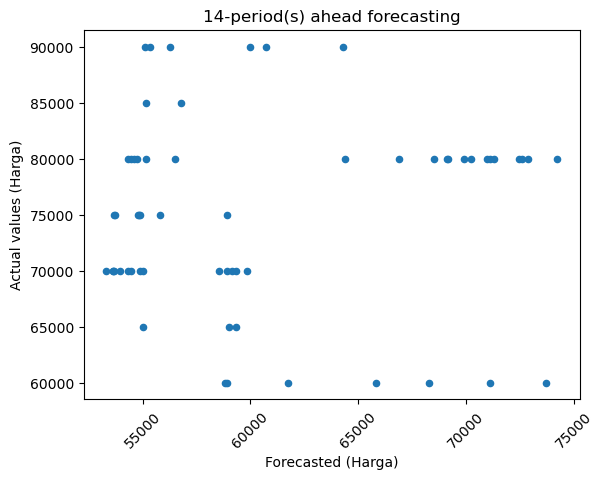

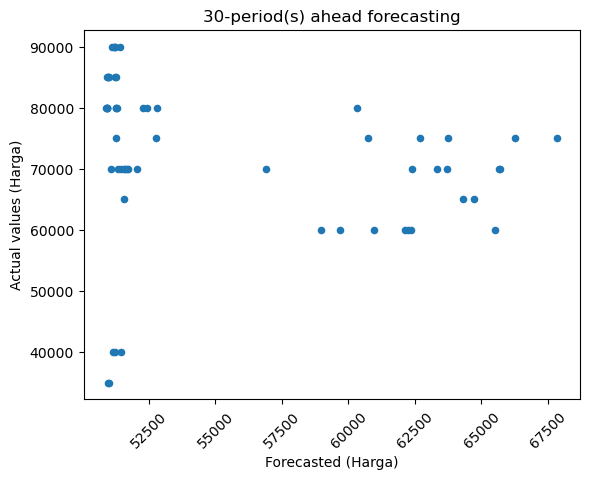

In [46]:
#f, ax = plt.subplots(nrows=3,ncols=2)
for t in periods:
    test_df[["target_t" + str(t), "pred_t" + str(t)]].plot(x="pred_t" + str(t), y="target_t" + str(t) ,kind="scatter")
    plt.title("{}-period(s) ahead forecasting".format(t))
    plt.xlabel("Forecasted (Harga)")
    plt.ylabel("Actual values (Harga)")
    plt.xticks(rotation=45)
    plt.show()

In [47]:
test_df.index = test_df.index.date

In [48]:
forecast_range = pd.date_range(start=np.max(test_df.index.values), periods=tau, freq="D")
len(forecast_range)

30

In [49]:
forecast = []
for t in range(0, tau):
    #print(-(t+1), (t))
    forecast = p_test[-(t+1):,(t)]*std+mean

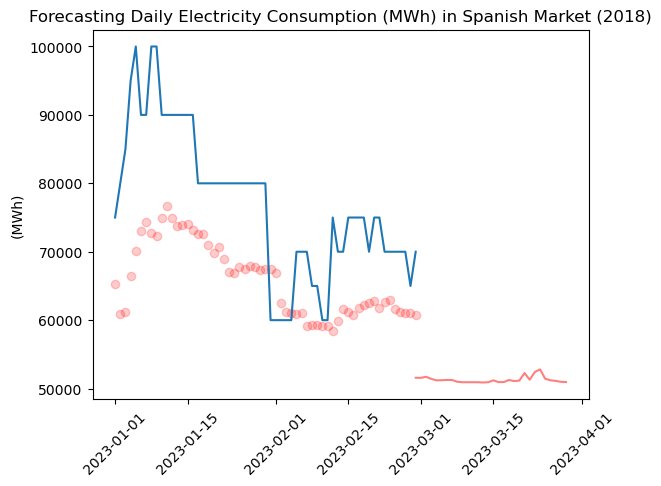

In [50]:
test_df["target_t1"].plot()
plt.scatter(x=test_df.index, y=test_df["pred_t1"], c="r", alpha=0.2, label="test preds")
plt.plot(forecast_range, forecast, c="r", alpha=0.5, label="forecasting")
plt.ylabel("(MWh)")
plt.xticks(rotation=45)
plt.title("Forecasting Daily Electricity Consumption (MWh) in Spanish Market (2018)")
plt.show()